# Capstone Project
## Probabilistic generative models
### Instructions

In this notebook, you will practice working with generative models, using both normalising flow networks and the variational autoencoder algorithm. You will create a synthetic dataset with a normalising flow with randomised parameters. This dataset will then be used to train a variational autoencoder, and you will used the trained model to interpolate between the generated images. You will use concepts from throughout this course, including Distribution objects, probabilistic layers, bijectors, ELBO optimisation and KL divergence regularisers.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports below. For this project you are free to make further imports throughout the notebook as you wish.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import numpy as np

import matplotlib
matplotlib.use('agg')

import matplotlib.pyplot as plt
%matplotlib inline

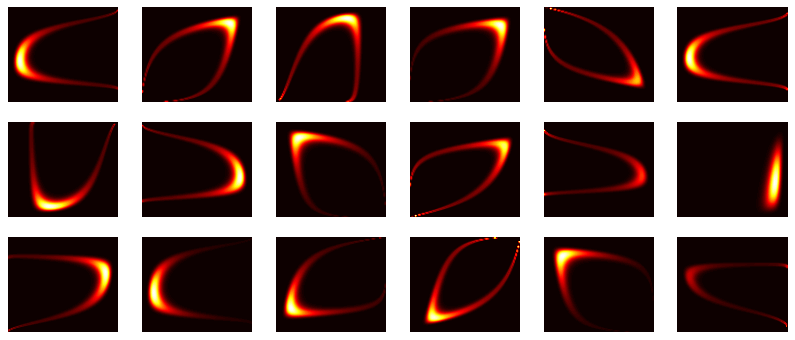

For the capstone project, you will create your own image dataset from contour plots of a transformed distribution using a random normalising flow network. You will then use the variational autoencoder algorithm to train generative and inference networks, and synthesise new images by interpolating in the latent space.

#### The normalising flow
* To construct the image dataset, you will build a normalising flow to transform the 2-D Gaussian random variable $z=(z_1, z_2)$, which has mean $\mathbf{0}$ and covariance matrix $\Sigma=\sigma^2\mathbf{I}_2$, with $\sigma=0.3$.
* This normalising flow uses bijectors that are parameterised by the following random variables:
  * $\theta \sim U[0, 2\pi)$
  * $a \sim N(3, 1)$
  
The complete normalising flow is given by the following chain of transformations:
* $f_1(z) = (z_1, z_2 - 2)$,
* $f_2(z) = (z_1, \frac{z_2}{2})$,
* $f_3(z) = (z_1, z_2 + az_1^2)$,
* $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$,
* $f_5(z) = \tanh(z)$, where the $\tanh$ function is applied elementwise.

The transformed random variable $x$ is given by $x = f_5(f_4(f_3(f_2(f_1(z)))))$.
* You should use or construct bijectors for each of the transformations $f_i$, $i=1,\ldots, 5$, and use `tfb.Chain` and `tfb.TransformedDistribution` to construct the final transformed distribution.
* Ensure to implement the `log_det_jacobian` methods for any subclassed bijectors that you write.
* Display a scatter plot of samples from the base distribution.
* Display 4 scatter plot images of the transformed distribution from your random normalising flow, using samples of $\theta$
and $a$. Fix the axes of these 4 plots to the range $[-1, 1]$.

In [2]:
# Define Third Bijector
class F3Bijector(tfb.Bijector):
    def __init__(self, validate_args=False, name="F3Bijector"):
        super(F3Bijector, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=1,
            name=name
        )
        self.a = tf.random.normal([1], mean=3., stddev=1.)

    def _forward(self, x):
        return tf.concat([
            x[..., :1],
            x[..., 1:] + self.a * tf.pow(x[..., :1], 2)
        ], axis = -1)

    def _inverse(self, y):
        return tf.concat([
            y[..., :1],
            y[..., 1:] - self.a * tf.pow(y[..., :1], 2)
        ], axis = -1)

    def _forward_log_det_jacobian(self, x):
        """
            df1/dx1 = 1  --  df2/dx1 = 2*a*x1
            df1/dx2 = 0  --  df2/dx2 = 1

            |det| = 1 - 2*a*x1 * 0 = 1
            log |det| = log 1 = 0
        """
        return tf.constant(0.)

    def _inverse_log_det_jacobian(self, x):
        """
            Assume g is f^{-1}
            dg1/dy1 = 1  --  dg2/dy1 = -2*a*y1
            dg1/dy2 = 0  --  dg2/dy2 = 1

            |det| = 1 + 2*a*y1 * 0 = 1
            log |det| = log 1 = 0
        """
        return tf.constant(0.)

In [3]:
import math as m

# Define Fourth Bijector
class F4Bijector(tfb.Bijector):
    def __init__(self, validate_args=False, name="F3Bijector"):
        super(F4Bijector, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=1,
            name=name
        )
        self.theta = tf.random.uniform([1], minval=0, maxval=2*m.pi)
        self.matrix = tf.squeeze([
            [tf.cos(self.theta), -tf.sin(self.theta)],
            [tf.sin(self.theta), tf.cos(self.theta)]
        ])
        self.transpose = tf.transpose(self.matrix)

    def _forward(self, x):
        return tf.linalg.matvec(self.matrix, x)

    def _inverse(self, y):
        return tf.linalg.matvec(self.transpose, y)

    def _forward_log_det_jacobian(self, x):
        """
            df1/dx1 = cos(theta)  --  df2/dx1 = sin(theta)
            df1/dx2 = -sin(theta)  --  df2/dx2 = cos(theta)

            |det| = cos^2(theta) + sin^2(theta) = 1
            log |det| = log 1 = 0
        """
        return tf.constant(0.)

    def _inverse_log_det_jacobian(self, x):
        """
            Assume g is f^{-1}
            dg1/dy1 = cos(theta)  --  dg2/dy1 = -sin(theta)
            dg1/dy2 = sin(theta)  --  dg2/dy2 = cos(theta)

            |det| = cos^2(theta) + sin^2(theta) = 1
            log |det| = log 1 = 0
        """
        return tf.constant(0.)

In [4]:
import math as m

def get_transformation_bijector():
    b_f1 = tfb.Shift([0., -2.])
    b_f2 = tfb.Scale([1., 0.5])
    b_f3 = F3Bijector()
    b_f4 = F4Bijector()
    b_f5 = tfb.Tanh()

    return tfb.Chain([
        b_f5, b_f4, b_f3, b_f2, b_f1
    ]), b_f3.a, b_f4.theta

def instantiate_transformed_dist(dist, bijector):
    return tfd.TransformedDistribution(
        distribution=dist, bijector=bijector
    )


In [5]:
def scatter_figure(ax, points, color="red", title="Figure", xlims=(-1,1), ylims=(-1,1)):
    ax.scatter(x=points[:, 0], y=points[:, 1], c = color)
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    ax.set_title(title)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    return ax

tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[], event_shape=[2], dtype=float32)


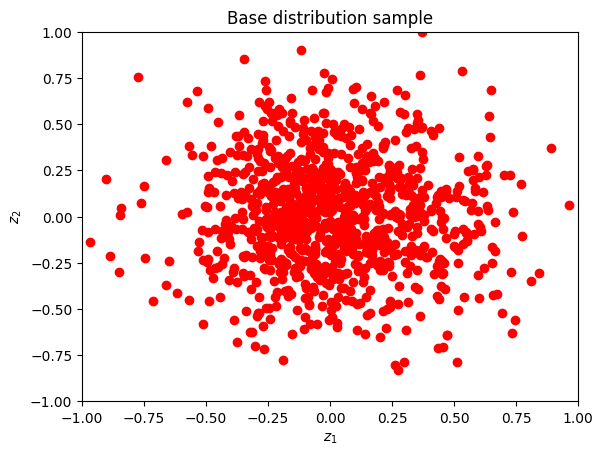

In [6]:
# Define base distribution
sigma = 0.3

base_loc = [0., 0.]
base_scale_diag = [sigma, sigma]

base_dist = tfd.MultivariateNormalDiag(
    loc=base_loc, scale_diag=base_scale_diag
)

print(base_dist)

fig, ax = plt.subplots()
_ = scatter_figure(
    ax, base_dist.sample(1000),
    "red", "Base distribution sample"
)

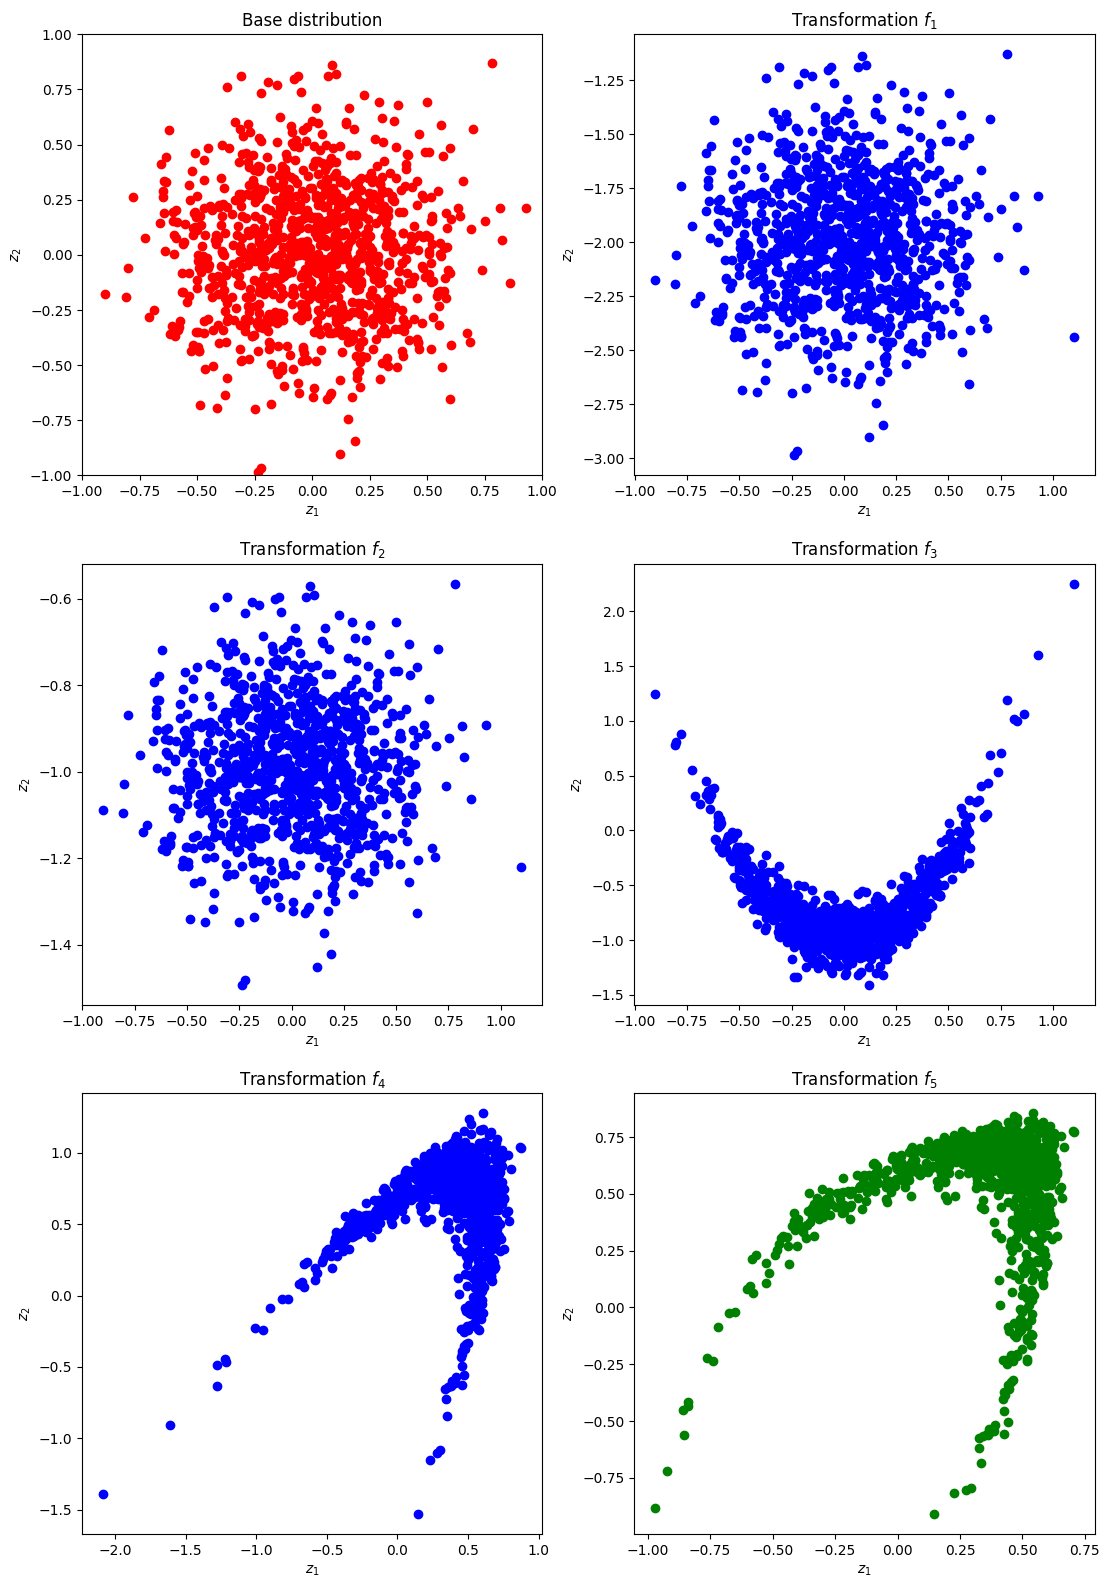

In [7]:
# Show steps for a single transformed distribution
chain_bijector, a, theta = get_transformation_bijector()

bijectors = chain_bijector.bijectors
n = len(bijectors)
h = base_dist.sample(1000)

fig, axes = plt.subplots((n+1) // 2, 2, figsize=(15,10))

plt.subplots_adjust(bottom=1, right=0.8, top=2.5)

scatter_figure(
    axes[0,0], h,
    "red", "Base distribution"
)

for i in range(1, n + 1):
    h = bijectors[n - i](h)
    title = f"Transformation $f_{i}$"
    color = "blue" if i < n else "green"
    scatter_figure(
        axes[i // 2, i % 2], h,
        color, title,
        None, None
    )

In [8]:
# Check transformed distribution shape
instantiate_transformed_dist(base_dist, chain_bijector).sample(10)

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 0.41447672,  0.69609207],
       [ 0.14864136,  0.6907403 ],
       [ 0.41610122,  0.7317118 ],
       [ 0.6183905 ,  0.4266317 ],
       [ 0.5798522 ,  0.41601926],
       [-0.14941712,  0.51819366],
       [ 0.48939526,  0.34552243],
       [ 0.41624838,  0.5996069 ],
       [ 0.34443274,  0.6742986 ],
       [ 0.58060324,  0.52035135]], dtype=float32)>

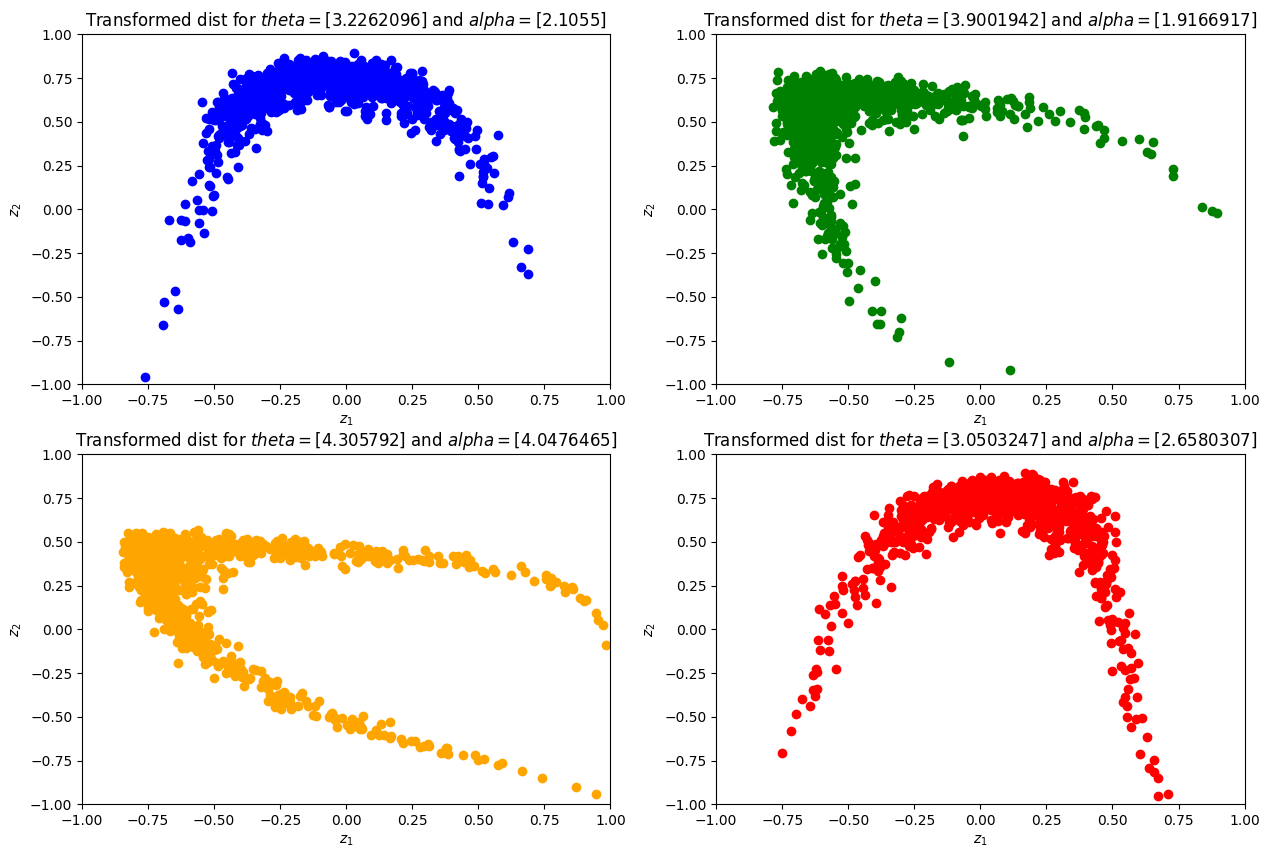

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

colors = ["blue", "green", "orange", "red"]
for i in range(4):
    x = i // 2
    y = i % 2

    chain_bijector, a, theta = get_transformation_bijector()
    samples = instantiate_transformed_dist(
        base_dist, chain_bijector
    ).sample(1000)

    title = f"Transformed dist for $theta={theta}$ and $alpha={a}$"
    scatter_figure(
        axes[x, y], samples,
        colors[i], title
    )

## 2. Create the image dataset
* You should now use your random normalising flow to generate an image dataset of contour plots from your random normalising flow network.
  * Feel free to get creative and experiment with different architectures to produce different sets of images!
* First, display a sample of 4 contour plot images from your normalising flow network using 4 independently sampled sets of parameters.
  * You may find the following `get_densities` function useful: this calculates density values for a (batched) Distribution for use in a contour plot.
* Your dataset should consist of at least 1000 images, stored in a numpy array of shape `(N, 36, 36, 3)`.  Each image in the dataset should correspond to a contour plot of a transformed distribution from a normalising flow with an independently sampled set of parameters $s, T, S, b$. It will take a few minutes to create the dataset.
* As well as the `get_densities` function, the `get_image_array_from_density_values` function will help you to generate the dataset.
  * This function creates a numpy array for an image of the contour plot for a given set of density values Z. Feel free to choose your own options for the contour plots.
* Display a sample of 20 images from your generated dataset in a figure.

In [10]:
# Helper function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [11]:
# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    size = 36
    inches = size / 100
    fig = Figure(figsize=(inches, inches))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0.)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

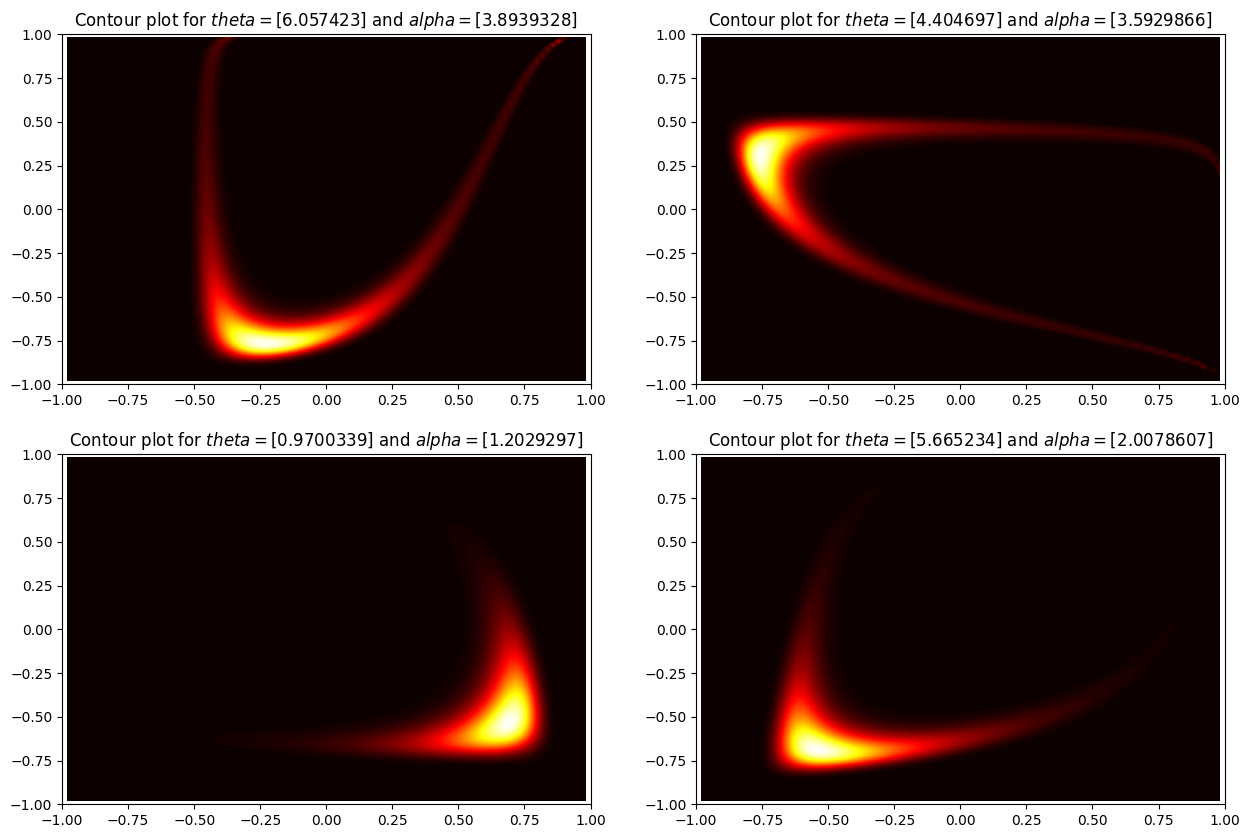

In [12]:
# Show 4 contour plots for different distributions

fig, axes = plt.subplots(2, 2, figsize=(15,10))

for i in range(4):
    x = i // 2
    y = i % 2

    chain_bijector, a, theta = get_transformation_bijector()
    dist = tfd.BatchReshape(instantiate_transformed_dist(
        base_dist, chain_bijector
    ), [1])

    Z = get_densities(dist).squeeze()
    axes[x,y].contourf(
        X, Y, Z, cmap='hot', levels=100
    )
    axes[x,y].axis("on")
    axes[x,y].set_title(f"Contour plot for $theta={theta}$ and $alpha={a}$")


Generated 100 images
Generated 200 images
Generated 300 images
Generated 400 images
Generated 500 images
Generated 600 images
Generated 700 images
Generated 800 images
Generated 900 images
Generated 1000 images
Generated 1100 images
Generated 1200 images
Generated 1300 images
Generated 1400 images
Generated 1500 images
Generated 1600 images
Generated 1700 images
Generated 1800 images
Generated 1900 images
Generated 2000 images
Generated 2100 images
Generated 2200 images
Generated 2300 images
Generated 2400 images
Generated 2500 images
Generated 2600 images
Generated 2700 images
Generated 2800 images
Generated 2900 images

Generated Image #0:



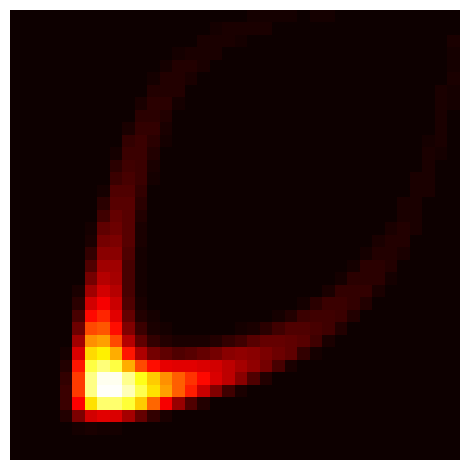

In [13]:
# Generate images for dataset

num_images = 3000
num_images_batch = 100

images_dataset = np.zeros((num_images, 36, 36, 3), dtype=np.int32)
plt.subplots_adjust(left=0, bottom=0)

for i in range(num_images):
    chain_bijector, a, theta = get_transformation_bijector()
    dist = tfd.BatchReshape(instantiate_transformed_dist(
        base_dist, chain_bijector
    ), [1])
    Z = get_densities(dist).squeeze()
    img = get_image_array_from_density_values(Z)
    images_dataset[i, ...] = img

    if i % num_images_batch == 0 and i > 0:
        print(f"Generated {i} images")

# Show a single image (actually helps with preventing loop from spamming lots of images at once)

print("\nGenerated Image #0:\n")
plt.imshow(images_dataset[0])
plt.axis("off")
plt.tight_layout()

plt.show()

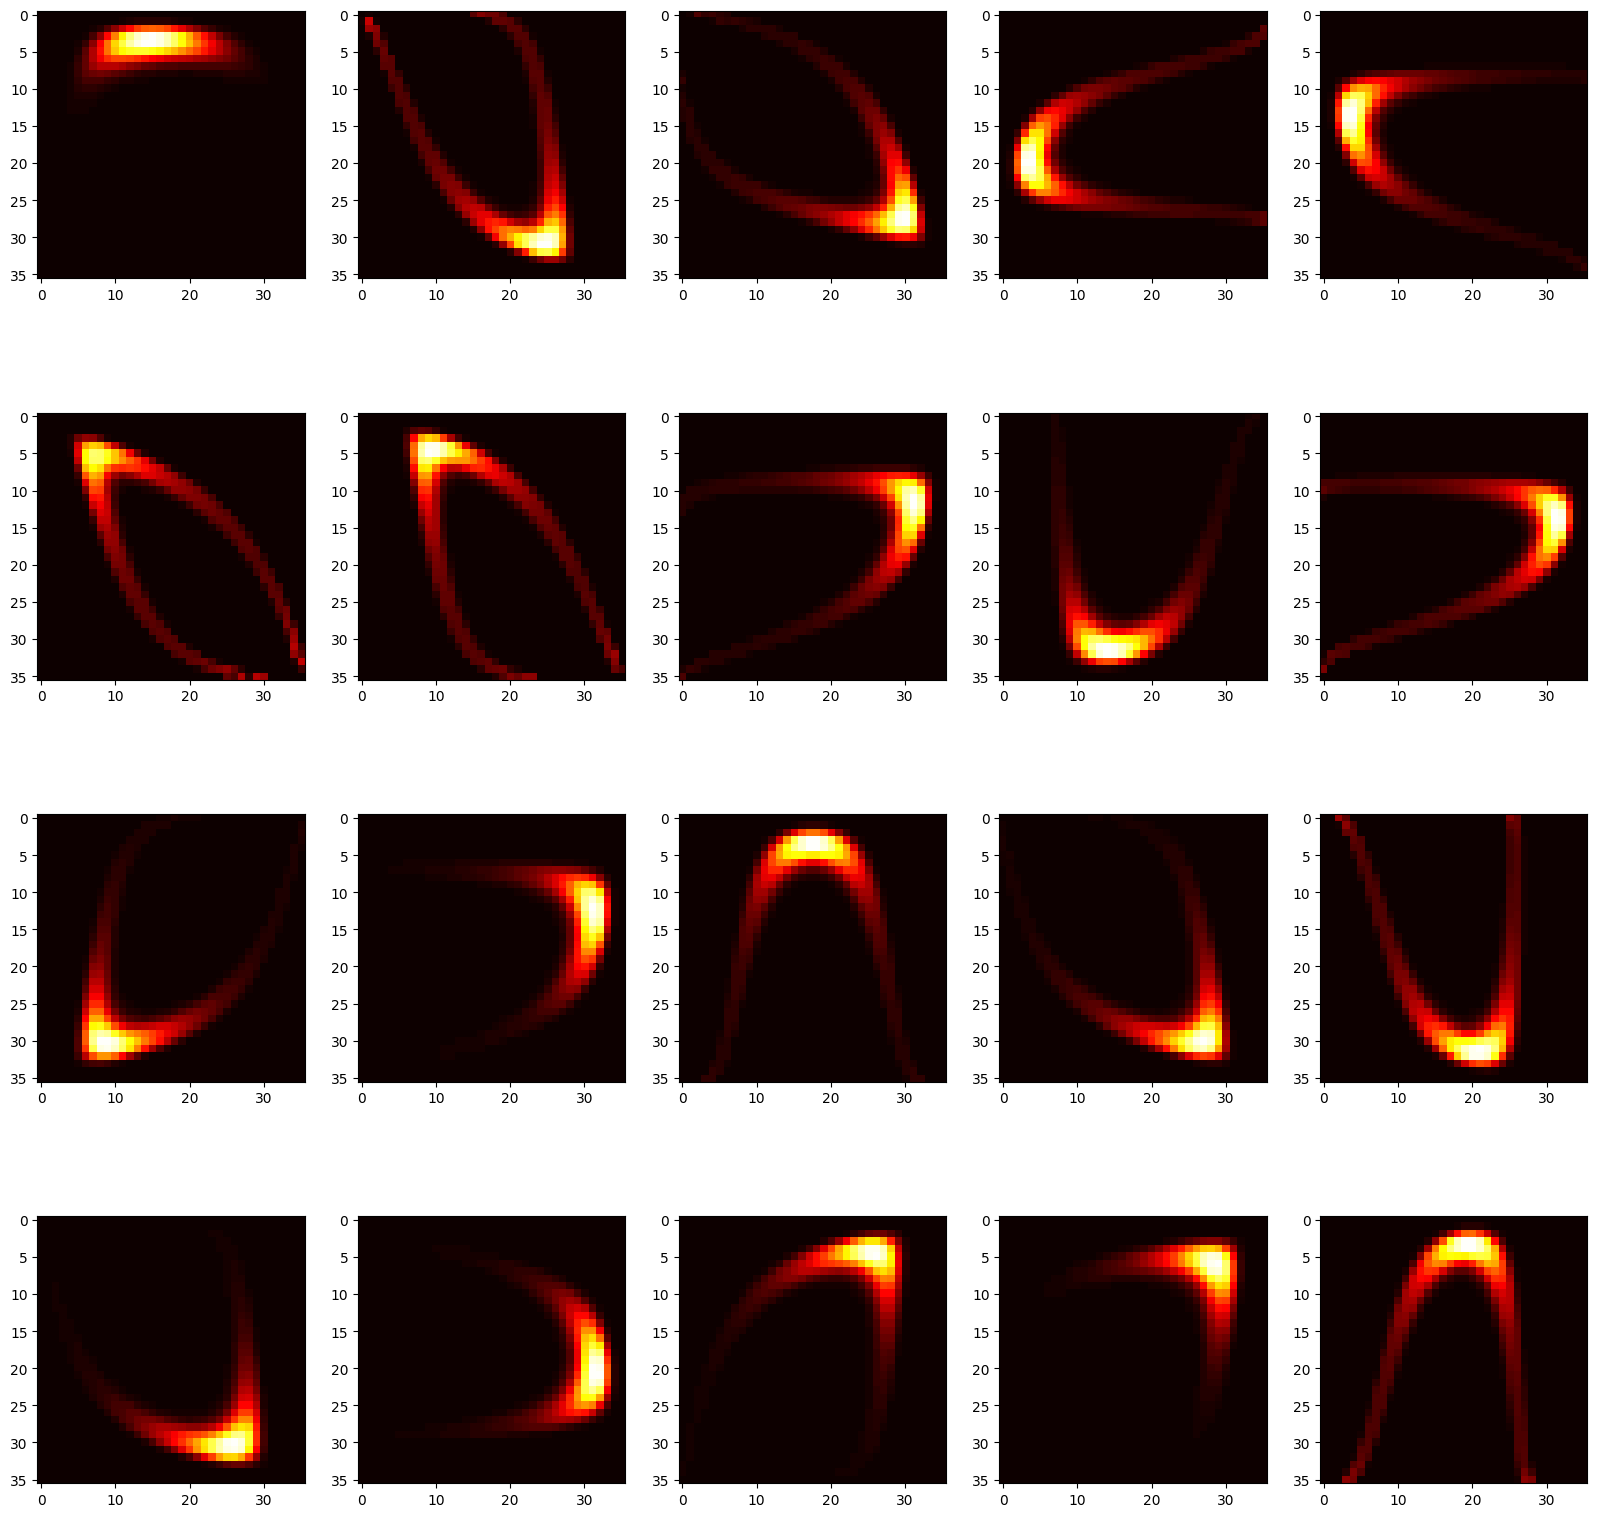

In [14]:
# Show 20 samples

fig, axes = plt.subplots(4, 5, figsize=(20,20))
indices = np.random.choice(
    list(range(num_images)),
    size=20, replace=False
)

for i in range(20):
    x = i // 5
    y = i % 5

    axes[x,y].imshow(images_dataset[indices[i]].astype(np.int32))
    axes[x,y].axis("on")

## 3. Make `tf.data.Dataset` objects
* You should now split your dataset to create `tf.data.Dataset` objects for training and validation data.
* Using the `map` method, normalise the pixel values so that they lie between 0 and 1.
* These Datasets will be used to train a variational autoencoder (VAE). Use the `map` method to return a tuple of input and output Tensors where the image is duplicated as both input and output.
* Randomly shuffle the training Dataset.
* Batch both datasets with a batch size of 20, setting `drop_remainder=True`.
* Print the `element_spec` property for one of the Dataset objects.

In [15]:
def plot_images(dataset, length=3):
  fig, axes = plt.subplots(1, length, figsize=(10,10))

  imgs = list(iter(dataset.take(length)))

  for i in range(length):
      if type(imgs[i]) is tuple:
        img = imgs[i][0]
      else:
        img = imgs[i]

      axes[i].imshow(img)
      axes[i].axis("off")

In [16]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(images_dataset, test_size=0.1)

train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
validation_dataset = tf.data.Dataset.from_tensor_slices(val_data)

In [17]:
def scale_images(dataset):
  def map_scale_image(img):
    return img / 255
  return dataset.map(map_scale_image)

train_dataset = scale_images(train_dataset)
validation_dataset = scale_images(validation_dataset)

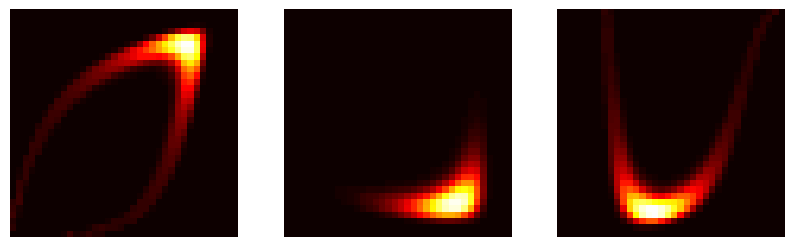

In [18]:
# See scaled imgs
plot_images(train_dataset)

In [19]:
def duplicate_images(dataset):
  def map_duplicate_image(img):
    return (img, img)
  return dataset.map(map_duplicate_image)

train_dataset = duplicate_images(train_dataset)
validation_dataset = duplicate_images(validation_dataset)

In [20]:
# Shuffle dataset
suffle_size = 100

train_dataset = train_dataset.shuffle(suffle_size)
validation_dataset = validation_dataset.shuffle(suffle_size)

In [21]:
# Batch datasets
batch_size = 20

train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
validation_dataset = validation_dataset.batch(batch_size, drop_remainder=True)

In [22]:
# See general datasets data

print("Train dataset: ")
print(train_dataset.element_spec)
print()

print("Validation dataset: ")
print(validation_dataset.element_spec)


Train dataset: 
(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float64, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float64, name=None))

Validation dataset: 
(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float64, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float64, name=None))


## 4. Build the encoder and decoder networks
* You should now create the encoder and decoder for the variational autoencoder algorithm.
* You should design these networks yourself, subject to the following constraints:
   * The encoder and decoder networks should be built using the `Sequential` class.
   * The encoder and decoder networks should use probabilistic layers where necessary to represent distributions.
   * The prior distribution should be a zero-mean, isotropic Gaussian (identity covariance matrix).
   * The encoder network should add the KL divergence loss to the model.
* Print the model summary for the encoder and decoder networks.

In [23]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization,
    Dense, Flatten, Reshape, UpSampling2D
)

In [24]:
latent_size = 16

In [25]:
# Define prior distribution
loc = tf.zeros((latent_size))
scale_diag = tf.ones((latent_size))
prior_dist = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag)

In [26]:
# Define the KL Divergence regularizer
kl_regularizer = tfpl.KLDivergenceRegularizer(
    prior_dist, use_exact_kl=False
)

In [65]:
encoder = Sequential([
  Conv2D(
      32, kernel_size=(3,3), activation="relu",
      padding="SAME", input_shape=(36,36,3),
  ),
  MaxPooling2D((2,2)),
  BatchNormalization(),
  Conv2D(
      64, kernel_size=(3,3), activation="relu",
      padding="SAME",
  ),
  MaxPooling2D((2,2)),
  BatchNormalization(),
  Conv2D(
      128, kernel_size=(2,2), activation="relu",
      padding="SAME",
  ),
  MaxPooling2D((2,2)),
  BatchNormalization(),
  Conv2D(
      256, kernel_size=(2,2), activation="relu",
      padding="SAME",
  ),
  Flatten(),
  Dense(256, activation="relu"),
  Dense(64, activation="relu"),
  Dense(
      tfpl.MultivariateNormalTriL.params_size(latent_size)
  ),
  tfpl.MultivariateNormalTriL(
      latent_size,
      activity_regularizer=kl_regularizer
  )
])

In [75]:
encoder.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 36, 36, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 18, 18, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_34 (Ba  (None, 18, 18, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_32 (Conv2D)          (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 9, 9, 64)          0         
 ng2D)                                                           
                                                     

In [69]:
decoder = Sequential([
      Dense(64, activation="relu", input_shape=(latent_size,)),
      Dense(2304, activation="relu"),
      Reshape((3, 3, 256)),
      Conv2DTranspose(
          256, kernel_size=(3,3),
          padding="VALID", activation="relu"
      ),
      UpSampling2D((2,2)),
      BatchNormalization(),
      Conv2DTranspose(
          64, kernel_size=(2,2), strides=(2,2),
          padding="VALID", activation="relu"
      ),
      UpSampling2D((2,2)),
      BatchNormalization(),
      Conv2D(
          3, kernel_size=(5,5),
          padding="VALID"
      ),
      Flatten(),
      tfpl.IndependentBernoulli(event_shape=(36,36,3))
  ])

In [74]:
decoder.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                1088      
                                                                 
 dense_37 (Dense)            (None, 2304)              149760    
                                                                 
 reshape_7 (Reshape)         (None, 3, 3, 256)         0         
                                                                 
 conv2d_transpose_14 (Conv2  (None, 5, 5, 256)         590080    
 DTranspose)                                                     
                                                                 
 up_sampling2d_8 (UpSamplin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                                 
 batch_normalization_37 (Ba  (None, 10, 10, 256)     

## 5. Train the variational autoencoder
* You should now train the variational autoencoder. Build the VAE using the `Model` class and the encoder and decoder models. Print the model summary.
* Compile the VAE with the negative log likelihood loss and train with the `fit` method, using the training and validation Datasets.
* Plot the learning curves for loss vs epoch for both training and validation sets.

In [70]:
model = Model(
    inputs=encoder.inputs,
    outputs=decoder(encoder.outputs)
)

In [175]:
# See model summary
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31_input (InputLaye  [(None, 36, 36, 3)]       0         
 r)                                                              
                                                                 
 conv2d_31 (Conv2D)          (None, 36, 36, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 18, 18, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_34 (Ba  (None, 18, 18, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_32 (Conv2D)          (None, 18, 18, 64)        18496     
                                                           

In [46]:
def nll(x_true, x_pred):
  return -tf.reduce_sum(x_pred.log_prob(x_true))

In [71]:
model.compile(
    optimizer="adam",
    loss=nll
)
history = model.fit(
    train_dataset, validation_data=validation_dataset,
    epochs=20
)

Epoch 1/20
135/135 [==============================] - 57s 390ms/step - loss: 16693.5039 - val_loss: 13461.7773
Epoch 2/20
135/135 [==============================] - 52s 386ms/step - loss: 8287.5996 - val_loss: 10885.7422
Epoch 3/20
135/135 [==============================] - 57s 417ms/step - loss: 7960.0542 - val_loss: 8667.7871
Epoch 4/20
135/135 [==============================] - 46s 344ms/step - loss: 7806.7036 - val_loss: 7907.7349
Epoch 5/20
135/135 [==============================] - 59s 441ms/step - loss: 7708.0132 - val_loss: 7680.7949
Epoch 6/20
135/135 [==============================] - 53s 395ms/step - loss: 7597.6904 - val_loss: 7697.1875
Epoch 7/20
135/135 [==============================] - 48s 357ms/step - loss: 7555.7710 - val_loss: 7776.6436
Epoch 8/20
135/135 [==============================] - 47s 345ms/step - loss: 7532.4097 - val_loss: 7538.8809
Epoch 9/20
135/135 [==============================] - 48s 356ms/step - loss: 7462.5620 - val_loss: 7462.2690
Epoch 10/20
135/

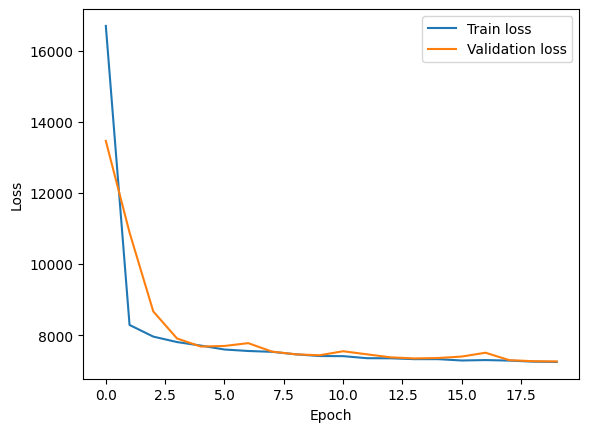

In [72]:
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## 6. Use the encoder and decoder networks
* You can now put your encoder and decoder networks into practice!
* Randomly sample 1000 images from the dataset, and pass them through the encoder. Display the embeddings in a scatter plot (project to 2 dimensions if the latent space has dimension higher than two).
* Randomly sample 4 images from the dataset and for each image, display the original and reconstructed image from the VAE in a figure.
  * Use the mean of the output distribution to display the images.
* Randomly sample 6 latent variable realisations from the prior distribution, and display the images in a figure.
  * Again use the mean of the output distribution to display the images.

In [156]:
# Scale original dataset images and shuffle
test_images = tf.constant(images_dataset) / 255

In [151]:
# Build encodings for data sample

embedded = encoder(test_images)

In [157]:
from sklearn.decomposition import PCA

# Project to 2D
pca = PCA(
    n_components=2,
)

embeded2d_full = pca.fit_transform(embedded.mean())
embedded2d = tf.random.shuffle(embeded2d_full)[:1000]

In [158]:
# Check result shape
print(embedded2d.shape)

(1000, 2)


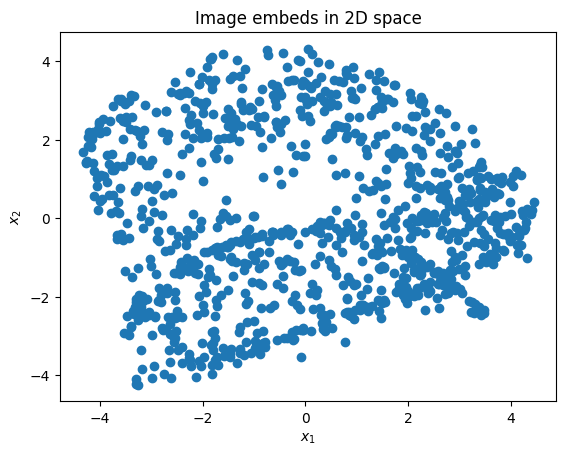

In [159]:
from sklearn.decomposition import PCA

plt.scatter(
    x=embedded2d[:, 0],
    y=embedded2d[:, 1],
)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Image embeds in 2D space")
plt.show()

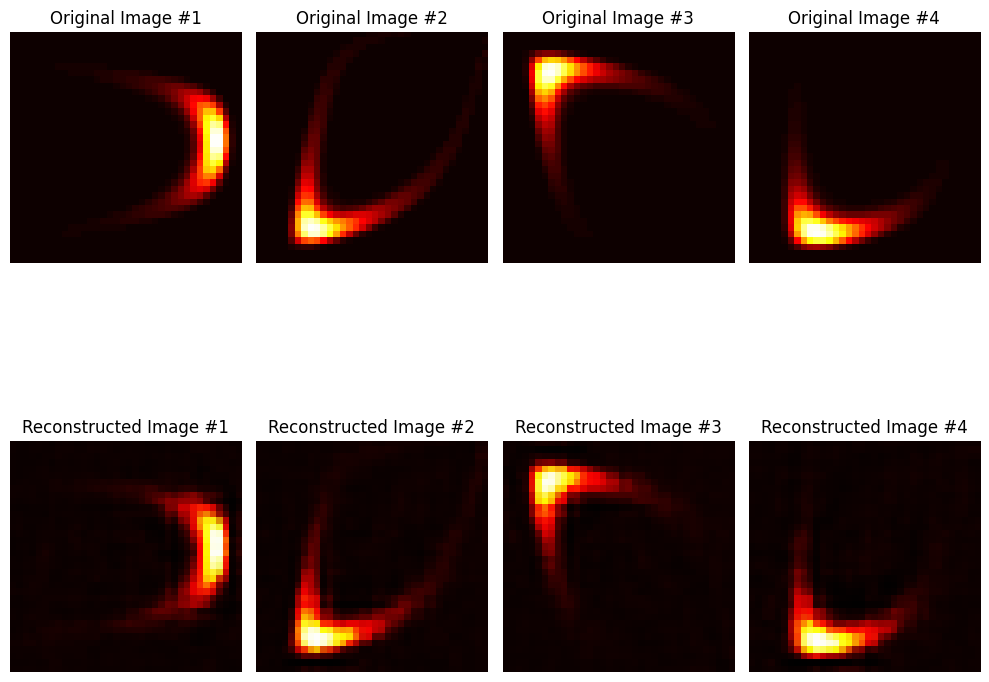

In [171]:
# Compare original vs reconstructed images
sampled_imgs = tf.random.shuffle(test_images)[:4]
encoded = encoder(sampled_imgs)
decoded_dists = decoder(encoded.mean())
reconstructed_imgs = decoded_dists.mean()

fig, axes = plt.subplots(2, 4, figsize=(10,10))

for i in range(4):
  axes[0, i].imshow(sampled_imgs[i])
  axes[0, i].axis("off")
  axes[0, i].set_title(f"Original Image #{i+1}")

  axes[1, i].imshow(reconstructed_imgs[i])
  axes[1, i].axis("off")
  axes[1, i].set_title(f"Reconstructed Image #{i+1}")

fig.tight_layout(
    h_pad=0.5
)

plt.show()

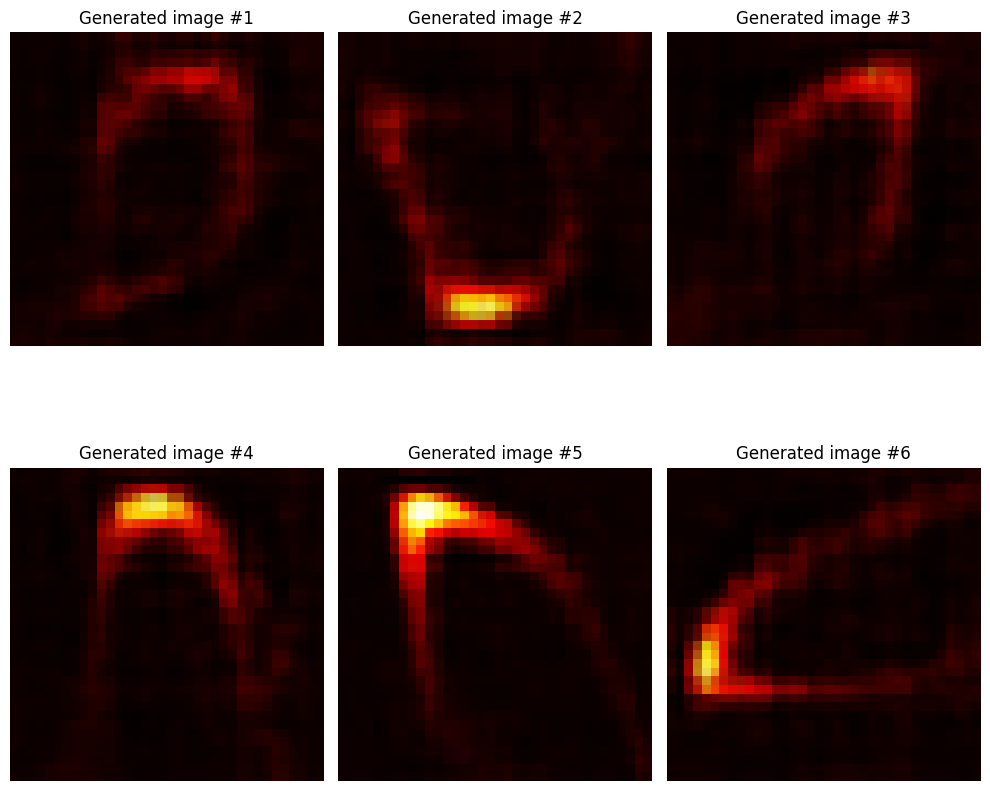

In [173]:
sampled_prior = prior_dist.sample(6)
generated_imgs = decoder(sampled_prior).mean()

fig, axes = plt.subplots(2, 3, figsize=(10,10))

for i in range(6):
  x = i // 3
  y = i % 3

  axes[x, y].imshow(generated_imgs[i])
  axes[x, y].axis("off")
  axes[x, y].set_title(f"Generated image #{i+1}")

fig.tight_layout(h_pad=0.05)

plt.show()

## Make a video of latent space interpolation (not assessed)
* Just for fun, you can run the code below to create a video of your decoder's generations, depending on the latent space.

In [174]:
# Function to create animation

import matplotlib.animation as anim
from IPython.display import HTML


def get_animation(latent_size, decoder, interpolation_length=500):
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(2 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i):
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data(z.numpy()[0], z.numpy()[1])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length,
                              repeat=False, blit=True, interval=150)

<ipython-input-115-8477254a2d74>:35: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(z.numpy()[0], z.numpy()[1])
<ipython-input-115-8477254a2d74>:35: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(z.numpy()[0], z.numpy()[1])


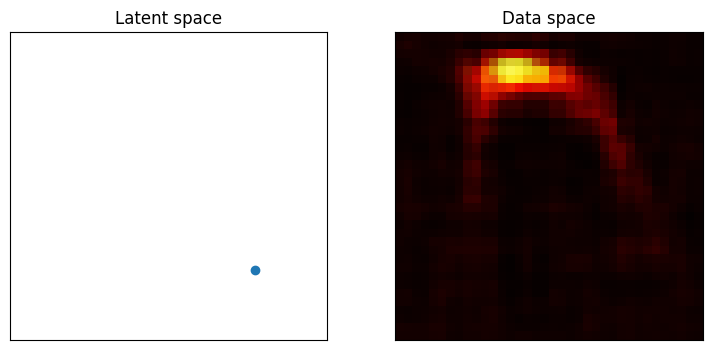

In [116]:
# Create the animation

a = get_animation(latent_size, decoder, interpolation_length=200)
HTML(a.to_html5_video())